<div align="center">

# **Procesamiento Avanzado en Comunicaciones Digitales**
## **Trabajo Final - Estimación de ICI realizando extracción de características a través de cumulantes y algoritmos de clasificación**

**Valentina Restrepo - Julián Sánchez**

</div>


# **Delimitación y descripción del problema**

Estimación de la ICI/OSNR usando 3 algoritmos de aprendizaje supervisado diferentes (SVM, KNN, Random Forest), con 
diferentes estrategias para extracción de características:

- métricas estadísticas como cumulantes por cada cluster (16 clusters, 16QAM):
    1. C21 (Potencia total de la señal)
    2.  C20 (Energía real para detectar desbalance I-Q)
    3. M42
    4. C42_img (Asimetrías de fase)
    5. C63_real (Estructura fina de modulación)
    6. C42_norm (Forma de la constenación)
    7. Q_std (Dispersión Q)
    8. IQ_corr (correlación I-Q)

Cada canal tiene **16 Gbaudios con roll-off de 0.1**, por lo que para un pulso con roll-off $\alpha$ y tasa de símbolos $R_s (Gbaud)$, el ancho de banda ocupado por canal es:


$BW_{ocupado} = R_s × (1 + \alpha)$

Y sustituyendo tendría:


$BW_{ocupado} = 16Gbaud × (1 + 0.1) = 16 × 1.1 = 17.6 GHz $

**Matriz de Características** Cada archivo .csv será un solo vector de 129 características por cada 10.000 símbolos.

$8$ features (cumulantes) $× 16$ clusters $ + 1 (SNR)= 128$ features para cada 10.000 símbolos.

Con 56 archivos para train, se tendría una trama total de **6096384** símbolos, por lo que la matriz de features tendría la forma:


$610$ muestras  $× 129$ features

# **Librerías**

In [75]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
import skfuzzy as fuzz
from sklearn.cluster import KMeans
import warnings
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# **Data Loading**

| carpeta | separation_GHz | occupied_bw_GHz | gap_GHz | label_by_occupied |
| ------: | :------------: | :-------------: | :-----: | :---------------: |
|   15GHz |      15.0      |       17.6      |   -2.6  |         1         |
| 15.5GHz |      15.5      |       17.6      |   -2.1  |         1         |
|   16GHz |      16.0      |       17.6      |   -1.6  |         1         |
| 16.5GHz |      16.5      |       17.6      |   -1.1  |         1         |
|   17GHz |      17.0      |       17.6      |   -0.6  |         1         |
| 17.6GHz |      17.6      |       17.6      |   0.0   |         0         |
|   18GHz |      18.0      |       17.6      |   +0.4  |         0         |

In [ ]:

# 1. Rutas de carpetas
BASE_PATH = './database'

carpetas = {
    "15GHz": 1,
    "15p5GHz": 1,
    "16GHz": 1,
    "16p5GHz": 1,
    "17GHz": 1,
    "17p6GHz": 0,   # sin ICI
    "18GHz": 0      # sin ICI
}

# Lista para guardar TODO
dataset = []

print("Cargando archivos :D")


# 2. Recorrer carpetas
for carpeta, etiqueta in carpetas.items():

    path = os.path.join(BASE_PATH, carpeta)  # entro en cada carpeta
    archivos = sorted([f for f in os.listdir(path) if f.endswith('.csv')])  # archivos CSV ordenados

    print(f"\n Carpeta: {carpeta}  |  Etiqueta ICI={etiqueta}  |  {len(archivos)} archivos")

    for archivo in archivos:
        file_path = os.path.join(path, archivo)

        # Cargar datos I/Q
        df = pd.read_csv(file_path)

        # Validar columnas
        if not {"I", "Q"}.issubset(df.columns):
            raise ValueError(f"El archivo {archivo} no tiene columnas I y Q.")

        # Extracción de SNR del nombre de cada archivo 
        match = re.search(r'(\d+)dB', archivo)
        snr = int(match.group(1)) if match else None

        # Guardar estructura
        dataset.append({
            "carpeta": carpeta,
            "archivo": archivo,
            "etiqueta": etiqueta,
            "snr": snr,          
            "data": df[["I", "Q"]]
        })

print("\nDatos cargados correctamente")


# 3. Split por archivo (NO mezclamos símbolos)
train_files, test_files = train_test_split(
    dataset,
    test_size=0.2, # 20% de los archivos totales serán test
    shuffle=True, # mezclar los archivos para evitar sesgos

    # Con stratify aseguro que se mantenga la proporción de clases (0,1) en ambos conjuntos
    # de train y test.
    stratify=[d["etiqueta"] for d in dataset]  # estratificación por ICI
)

print(f"\nArchivos para TRAIN: {len(train_files)}")
print(f"Archivos para TEST:  {len(test_files)}")



Cargando archivos :D

 Carpeta: 15GHz  |  Etiqueta ICI=1  |  7 archivos

 Carpeta: 15p5GHz  |  Etiqueta ICI=1  |  9 archivos

 Carpeta: 16GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 16p5GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 17GHz  |  Etiqueta ICI=1  |  11 archivos

 Carpeta: 17p6GHz  |  Etiqueta ICI=0  |  11 archivos

 Carpeta: 18GHz  |  Etiqueta ICI=0  |  10 archivos

Datos cargados correctamente

Archivos para TRAIN: 56
Archivos para TEST:  14


In [3]:
dataset_init = dataset
dataframe_init = pd.DataFrame(dataset_init)

dataframe_init

,carpeta,archivo,etiqueta,snr,data
0,15GHz,16QAM_3x16GBd_consY23dB.csv,1,23,I Q 0 2.356595 1...
1,15GHz,16QAM_3x16GBd_consY25dB.csv,1,25,I Q 0 2.576490 -3...
2,15GHz,16QAM_3x16GBd_consY27dB.csv,1,27,I Q 0 1.701967 2...
3,15GHz,16QAM_3x16GBd_consY30dB.csv,1,30,I Q 0 -3.075793 2...
4,15GHz,16QAM_3x16GBd_consY32dB.csv,1,32,I Q 0 3.042746 -3...
...,...,...,...,...,...
65,18GHz,16QAM_3x16GBd_consY27dB.csv,0,27,I Q 0 -0.956442 0...
66,18GHz,16QAM_3x16GBd_consY30dB.csv,0,30,I Q 0 -3.173633 1...
67,18GHz,16QAM_3x16GBd_consY32dB.csv,0,32,I Q 0 2.609396 -1...
68,18GHz,16QAM_3x16GBd_consY35dB.csv,0,35,I Q 0 2.918820 -3...


# **Segmentación del Dataset**

Se tomará cada archivo y se segmentará en ventanas de 10.000 símbolos, las ventanas que queden incompletas (menos de 10.000 símbolos) se descartarán, ya que implementarlas introduciría errores o problemas como:

- Con menos muestras, los estimadores o cumulantes serán más ruidosos y sesgados, afectando la estabilidad del modelo.
- Si se completan los 10.000 símbolos con la trama de puntos I/Q siguientes, se incluirán puntos de otros archivos con un SNR diferente.
- Si se trabaja con ventanas de diferentes tamaños, se aumenta considerablemente la complejidad del proyecto, además de que habría que incluir estrategias para mitigar el desbalanceo por falta de muestras en ventanas con menos de 10.000 símbolos.
- Si se toman símbolos faltantes del mismo archivo, se repetirían datos y se tendría el mismo problema que si no se tuvieran los 10.000 símbolos completos: la ventana parcial sería menor y tendría estimadores más ruidosos y posiblemente, sesgados.

Así, de cada archivo se extraerán **10 ventanas completas de 10.000 símbolos**, se descartarán las 8864 muestras restantes.

Para generar las **10 ventanas de 10000 símbolos por archivo**, se implementará una función que:

1. Tomar un archivo del diccionario (diccionario de test o train)
2. Obtener sus puntos I/Q
3. Dividir en ventanas consecutivas de 10000 símbolos
4. Descartar la ventana sobrante si no completa 100000
5. Devolver una lista de ventanas, cada una con:
    - Matriz Nx2 (I,Q)
    - La carpeta
    - El SNR
    - La etiqueta ICI
    - El nombre del archivo


    {
   "I": array,
   "Q": array,
   "data": array Nx2,
   "carpeta": ...,
   "snr": ...,
   "etiqueta": ...,
   "archivo": ...,
   "id_ventana": k
}


In [4]:
WINDOW_SIZE = 10000

def segmentar_ventanas(archivos):
    ventanas = []
    for archivo in archivos:
        data = archivo['data'] # puntos I/Q
        total_simbolos = len(data) # 108865
        n_ventanas = total_simbolos // WINDOW_SIZE  # número de ventanas completas

        # con un ciclo interno, se seleccionan porciones consecutivas de los datos,
        # desde el símbolo i*10000 hasta (i+1)10000
        # reset_index(drop=True) es para que el índice del dataframe ventana sea limpio y consecutivo.
        for i in range(n_ventanas):
            ventana_data = data.iloc[i*WINDOW_SIZE:(i+1)*WINDOW_SIZE].reset_index(drop=True)
            
            ventanas.append({
                "carpeta": archivo['carpeta'],
                "archivo": archivo['archivo'],
                "etiqueta": archivo['etiqueta'],
                "snr": archivo['snr'],
                "data": ventana_data
            })
    return ventanas

ventanas_train = segmentar_ventanas(train_files)
ventanas_test = segmentar_ventanas(test_files)

print(f"Ventanas de train: {len(ventanas_train)}")
print(f"Ventanas de test: {len(ventanas_test)}")


Ventanas de train: 560
Ventanas de test: 140


In [5]:
df_train = pd.DataFrame(ventanas_train)
df_train

,carpeta,archivo,etiqueta,snr,data
0,17p6GHz,16QAM_3x16GBd_consY40dB.csv,0,40,I Q 0 2.828578 -0.528...
1,17p6GHz,16QAM_3x16GBd_consY40dB.csv,0,40,I Q 0 0.678732 1.154...
2,17p6GHz,16QAM_3x16GBd_consY40dB.csv,0,40,I Q 0 -2.684456 -2.810...
3,17p6GHz,16QAM_3x16GBd_consY40dB.csv,0,40,I Q 0 2.402690 2.603...
4,17p6GHz,16QAM_3x16GBd_consY40dB.csv,0,40,I Q 0 -3.132346 -0.720...
...,...,...,...,...,...
555,15GHz,16QAM_3x16GBd_consY35dB.csv,1,35,I Q 0 -0.140719 -1.871...
556,15GHz,16QAM_3x16GBd_consY35dB.csv,1,35,I Q 0 3.230897 1.201...
557,15GHz,16QAM_3x16GBd_consY35dB.csv,1,35,I Q 0 -2.129168 2.710...
558,15GHz,16QAM_3x16GBd_consY35dB.csv,1,35,I Q 0 2.623452 -1.286...


In [6]:
df_test = pd.DataFrame(ventanas_test)
df_test

,carpeta,archivo,etiqueta,snr,data
0,15p5GHz,16QAM_3x16GBd_consY40dB.csv,1,40,I Q 0 0.593951 -1.136...
1,15p5GHz,16QAM_3x16GBd_consY40dB.csv,1,40,I Q 0 -0.415369 2.671...
2,15p5GHz,16QAM_3x16GBd_consY40dB.csv,1,40,I Q 0 3.382266 0.642...
3,15p5GHz,16QAM_3x16GBd_consY40dB.csv,1,40,I Q 0 2.941567 0.793...
4,15p5GHz,16QAM_3x16GBd_consY40dB.csv,1,40,I Q 0 1.124839 2.972...
...,...,...,...,...,...
135,15GHz,16QAM_3x16GBd_consY32dB.csv,1,32,I Q 0 -1.534929 -2.782...
136,15GHz,16QAM_3x16GBd_consY32dB.csv,1,32,I Q 0 2.981522 -0.836...
137,15GHz,16QAM_3x16GBd_consY32dB.csv,1,32,I Q 0 3.368408 -2.122...
138,15GHz,16QAM_3x16GBd_consY32dB.csv,1,32,I Q 0 -2.432129 -2.783...


# **Puntos Ideales de la Constelación**

La potencia en señales complejas hace referencia a cuánta energía tiene la señal en promedio.
La potencia de un punto I/Q es la distancia al origen al cuadrado:

$Potencia = I^2 + Q^2$

Si se promedia la potencia de todos los símbolos, se obtiene la potencia media de la constelación.


¿Por qué normalizar?
Si no se normaliza, los puntos pueden estar muy dispersos o muy juntos y eso podría afectar las comparaciones y el entrenamiento de modelos.
Al escalar la constelación para que su potencia promedio sea 1, se está poniendo la señal en una escala estándar común que facilita el análisis y la comparación.

In [7]:

def generar_constelacion_16QAM():
    
    # Valores típicos para 16QAM, con niveles en I y Q: -3, -1, +1, +3
    niveles = np.array([-3, -1, 1, 3])
    
    '''
    Se crean dos matrices 2D I y Q que contienen todas las combinaciones posibles
    entre los valores de niveles para I y Q.
    '''
    I, Q = np.meshgrid(niveles, niveles)
    
    ''' 
    Se aplanan ambas matrices con ravel para obtener vectores 1D, luego se apilan 
    verticalmente con vstack, quedando un arreglo de 2x16 (porque hay 16 combinaciones).
    Finalmente, se transpone con .T para que quede un arreglo 16x2, donde cada fila
    es un punto I/Q de la constelación ideal.
    '''
    constelacion = np.vstack([I.ravel(), Q.ravel()]).T
    
    '''
    Se calcula la potencia media de todos los puntos de la constelación.
    Esto se hace elevando al cuadrado la magnitud (distancia al origen) de cada punto
    y calculando su promedio.
    Esto para estandarizar la señal
    '''
    potencia_media = np.mean(np.abs(constelacion)**2)

    ''' 
    Se normalizan los puntos dividiendo por la raíz cuadrada de la potencia media,
    de modo que la potencia promedio final de la constelación sea 1.

    Esto para que al comparar o entrenar modelos, no influya la escala
    '''
    constelacion_normalizada = constelacion / np.sqrt(potencia_media)
    
    return constelacion_normalizada

puntos_ideales = generar_constelacion_16QAM()
print(puntos_ideales)



[[-1.34164079 -1.34164079]
 [-0.4472136  -1.34164079]
 [ 0.4472136  -1.34164079]
 [ 1.34164079 -1.34164079]
 [-1.34164079 -0.4472136 ]
 [-0.4472136  -0.4472136 ]
 [ 0.4472136  -0.4472136 ]
 [ 1.34164079 -0.4472136 ]
 [-1.34164079  0.4472136 ]
 [-0.4472136   0.4472136 ]
 [ 0.4472136   0.4472136 ]
 [ 1.34164079  0.4472136 ]
 [-1.34164079  1.34164079]
 [-0.4472136   1.34164079]
 [ 0.4472136   1.34164079]
 [ 1.34164079  1.34164079]]


# **Asignación de Clusters a las Ventanas con KNN** Revisar

In [8]:

# Crear el clasificador KNN entrenado con los puntos ideales y etiquetas (0 a 15)
etiquetas_clusters = np.arange(len(puntos_ideales))


 # se instancia un clasificador KNN con k=1, de modo que solo se fije en el
 # único vecino más cercano
knn = KNeighborsClassifier(n_neighbors=1)

# se entren con los puntos ideales como datos de entrenamiento
knn.fit(puntos_ideales, etiquetas_clusters)

def asignar_clusters(datos_ventana):
    '''
    datos_ventana: DataFrame con columnas 'I' y 'Q' para 10.000 símbolos
    Retorna un array con la etiqueta de cluster asignada a cada símbolo
    '''
    puntos = datos_ventana[['I', 'Q']].values
    clusters_asignados = knn.predict(puntos)
    return clusters_asignados

# Ejemplo de uso con una ventana cualquiera
clusters = asignar_clusters(ventanas_train[400]['data'])
print(clusters[:100])



[14  3  0 11 12  1  3 12  4 11 15 14 12  0  3 15 13 12  8  1 12  3  4 14
  1 15  3  4 13  3 13 12 11  8  8  8 14 11  3 11 12 13  0  9  7 12 11  3
  0  0  0  3 15  0 10  5  8 15  2  0  8  8  3  2 12 15  4 12 11  3  0 15
 12 15 15 12 11  8 11 15 12 15 15  1  4 12  1 15  0  0 12  2 12  0 14  2
  0  0  0 12]


In [9]:

# Asignar clusters a TODAS las ventanas de train
clusters_train = []   # aquí guardaremos un array por cada ventana

for ventana in ventanas_train:
    datos = ventana['data']  # DataFrame con columnas I y Q
    etiquetas = asignar_clusters(datos)
    clusters_train.append(etiquetas)

print("Clusters asignados para train:", len(clusters_train))



# Asignar clusters a TODAS las ventanas de test
clusters_test = []

for ventana in ventanas_test:
    datos = ventana['data']
    etiquetas = asignar_clusters(datos)
    clusters_test.append(etiquetas)

print("Clusters asignados para test:", len(clusters_test))


Clusters asignados para train: 560
Clusters asignados para test: 140


## **Distribrución de Clusters por Ventana**

Se busca verificar el porcentaje de símbolos en cada uno de los 16 clusters en todas las ventanas.

Esto para entender si hay ventanas donde falta casi por completo algún cluster, lo que podría afectar los cumulantes.

- Si hay clusters con menos del ~1% de símbolos darán como resultado cumulantes muy inestables.
- Si hay clusters con 0 símbolos, el cumulante de ese cluster debe ser tratado como 0 o NaN.


In [10]:

def distribucion_clusters_ventana(ventana):
    '''
    ventana: diccionario que contiene ventana['data'] con columnas I, Q

    ventana debe tener ya los clusters asignados, en ventana['clusters']

    ventana['clusters'] es un array 1D con las etiquetas de cluster para cada
    símbolo, por lo que contiene enteros entre 0 y 15.
    '''


    '''
    se cuenta cuántas veces aparece cada entero en el array ventana['clusters'],
    y devuelve un vector donde la posición i contiene el conteo del cluster i.
    minlength=16 fuerza que el resultado tenga longitud 16 (una fila por cada cluster)

    Ejemplo: si el cluster 0 aparece 600 veces y cluster 1 aparece 400 veces, counts[0] == 600, counts[1] == 400, etc.
    '''
    counts = np.bincount(ventana['clusters'], minlength=16)

    # se normalizan los conteos para convertirlos en fracciones
    porcentajes = counts / np.sum(counts)


    # Dataframe con 3 columnas
    df = pd.DataFrame({
        "cluster": np.arange(16), # índice identificador del cluster (0,...,15)
        "conteo": counts, # cantidad de símbolos asignados a ese cluster
        "porcentaje": porcentajes # conteo normalizado dividido por el total [0,1]
    })
    return df

# Implementación
for v in ventanas_train:
    v["clusters"] = asignar_clusters(v["data"])

for v in ventanas_test:
    v["clusters"] = asignar_clusters(v["data"])

# Ejemplo Distribución de la primera ventana de train y test
dist = distribucion_clusters_ventana(ventanas_train[0])
print(dist)


distr = distribucion_clusters_ventana(ventanas_test[0])
print(distr)


    cluster  conteo  porcentaje
0         0    1369      0.1369
1         1     426      0.0426
2         2     281      0.0281
3         3    1744      0.1744
4         4     651      0.0651
5         5     117      0.0117
6         6      67      0.0067
7         7     330      0.0330
8         8     204      0.0204
9         9      32      0.0032
10       10      88      0.0088
11       11     421      0.0421
12       12    2115      0.2115
13       13     207      0.0207
14       14     601      0.0601
15       15    1347      0.1347
    cluster  conteo  porcentaje
0         0    1284      0.1284
1         1     495      0.0495
2         2     357      0.0357
3         3    1608      0.1608
4         4     602      0.0602
5         5     135      0.0135
6         6     121      0.0121
7         7     376      0.0376
8         8     361      0.0361
9         9      93      0.0093
10       10     144      0.0144
11       11     447      0.0447
12       12    1772      0.1772
13      

Ejemplo para la primera ventana del dataset de train, en el que se observa que todos los 16 clusters están presentes. Se observa que la distribución de símbolos no es totalmente uniforme porque hay que tener en cuenta que estamos observando una porción del experimento (10000 símbolos de 108865), la constelación real está degradada por el canal, hay ICI, la normalización y el ruido hacen que algunos símbolos se asignen a clusters vecinos y las zonas superiores suelen tener más puntos debido al mapeo Gray + características del transmisor.

# **Extracción de Características**

## Un poquito de contexto

Un cumulante es una medida que describe la forma de un conjunto de puntos, un cluster en este caso. 

Permiten medir:
- Qué tan dispersos están (energía)
- Qué tan estirados están (kurtosis)
- Presencia de rotación
- Si están aplastados o abiertos
- Distorsiones no lineales
- Presencia de ruido aditivo
- Concidencia de la forma con una 16QAM, 64QAM, PSK, etc.

Es como si los cumulantes dieran una **huella única** de cada tipo de modulación.

Se derivan de los momentos estadísticos pero eliminan dependencias entre ellos.

Propiedades técnicas clave:
- Algunos son invariantes a rotaciones
- Para ruido gaussiano blanco, todos los cumulantes de orden >2 valen cero
- Para señales moduladas, los cumulantes tienen valores característicos


1. **Re(C20)** Simetría real, rotación horizontal.
2. **Im(C20)** Simetría imaginaria, rotación vertical.
3. **C21** Energía promedio del cluster. Está directamente relacionada con el SNR y la potencia.
4. **Re(C40)** Kurtosis real, qué tan alargado está el cluster.
5. **Im(C40)** Kurtosis compleja, inclinación o shearing.
6. **Re(C41)** Forma combinada entre energía y dispersión del cluster.
7. **Im(C41)** Captura deformaciones diagonales o potencia en brazos laterales.
8. **C42** Sirve para distinguir entre QPSK, 16QAM, 64QAM. Es más robusto contra el ruido.

[1] A. Swami and B. M. Sadler,

"Hierarchical Digital Modulation Classification Using Cumulants,"
IEEE Transactions on Communications, 2000.

[2] H. H. Khallaf,

"Modulation Classification Using Higher Order Cumulants,"
IEEE MILCOM, 2005.

[3] S. M. Kay,

Fundamentals of Statistical Signal Processing, Vol. 1 & 2.
(Clásico en cumulantes y momentos).

[4] Proakis & Salehi,

Digital Communications, 5th Ed.
(Sección de modulación QAM y cumulantes).

[5] IEEE Signal Processing Magazine – Tutorial series on cumulants.

## **Funciones**

In [11]:
# Función para calcular cumulantes de un cluster (8 cumulantes)

def cumulantes_cluster(I, Q):
    '''
    I y Q son arrays 1D con los puntos de un cluster.
    Retorna los 8 cumulantes definidos para 16QAM.
    '''

    z = I + 1j*Q # construye los números complejos del cluster

    # Momentos crudos (raw moments) que representan la dispersión y forma del cluster
    m2 = np.mean(np.abs(z)**2) # momento de orden 2 (energía promedio del cluster)
    m4 = np.mean(np.abs(z)**4) # momento de orden 4
    m6 = np.mean(np.abs(z)**6) # momento de orden 6

    # Momentos complejos mixtos
    m20 = np.mean(z**2) # captura asimetrías o rotaciones del cluster
    m40 = np.mean(z**4)
    m42 = np.mean((z**2) * (np.abs(z)**2)) 

    # Cumulantes, que son combinaciones de momentos que eliminan redundancia
    # distiguen muy bien ruido, rotación, forma de constelación y distribución
    C20 = m20
    C21 = m2
    C40 = m40 - 3*(m20**2) # mide kurtosis compleja (forma del cluster, aplanamiento)
    C41 = m42 - 3*m20*m2 # relaciona la forma con la energía
    C42 = m4 - abs(m20)**2 - 2*(m2**2) # detecta modulación y ruido no lineal
    C60 = m6 - 15*np.real(m4*m2) + 30*(m20**3) # mide forma avanzada del cluster y no linealidades de alto orden
    C63 = m6 - 6*m4*m2 + 9*(m2**3) # captura asimetrías y deformaciones moderadas
    C80 = (m4**2) - 12*m4*(m2**2) + 18*(m2**4) 

    return np.array([np.real(C20), np.imag(C20), 
                     C21, 
                     np.real(C40), np.imag(C40),
                     np.real(C41), np.imag(C41),
                     C42])


In [12]:
# Función para procesar una ventana completa (128 cumulantes + SNR)

def extraer_features_ventana(ventana):
    '''
    ventana: diccionario con 'data', 'clusters' y 'snr'
    Retorna vector de 129 características.
    '''
    
    data = ventana['data'] # se extrae el dataframe con los puntos
    clusters = ventana['clusters'] # se extrae el array con las etiquetas del cluster, una por punto

    features = [] # lista vacía donde se guardarán las 129 features finales

    # Para cada cluster 0-15
    for k in range(16):
        idx = (clusters == k) 
        puntos = data[idx] # extrae solo los puntos del cluster k desde el dataframe

        I = puntos['I'].values
        Q = puntos['Q'].values

        cumul = cumulantes_cluster(I, Q) # cumul = [C20_real, C20_imag, C21, C40_real, C40_imag, C41_real, C41_imag, C42]
        features.extend(cumul)

    # se añade el SNR
    features.append(ventana['snr'])

    return np.array(features, dtype=float)


In [13]:

# DATASET DE TRAIN
X_train = [] # array que contendrá las features de cada ventana de train
y_train = [] # array que contendrá la etiqueta ICI asociada a cada ventana de train

for v in ventanas_train: # se recorre cada ventana del conjunto de train
    v_features = extraer_features_ventana(v) # calcula los 129 features de esa ventana
    X_train.append(v_features) # añade esas 129 features 
    y_train.append(v['etiqueta']) # añade la etiqueta ICI de la ventana

X_train = np.array(X_train)
y_train = np.array(y_train)


# DATASET DE TEST
X_test = [] # array que contendrá las features de cada ventana de test
y_test = [] # array que contendrá la etiqueta ICI asociada a cada ventana de test

for v in ventanas_test:
    v_features = extraer_features_ventana(v)
    X_test.append(v_features)
    y_test.append(v['etiqueta'])

X_test = np.array(X_test)
y_test = np.array(y_test)


In [14]:
# Datasets de train o test sin SNR

# Todas las filas, todas las columnas excepto la última
X_train_sin_snr = X_train[:, :-1]  
X_test_sin_snr = X_test[:, :-1]

# **Preprocesamiento y Análisis de Características**

Se busca revisar si hay características (cumulantes o clusters) que aportan poco o que están muy correlacionadas y podrían ser redundantes, para mejorar el rendimiento, reducir el ruido y evitar el overfitting.

| Criterio              | Método de correlación                | Método de baja varianza                |
| --------------------- | ------------------------------------ | -------------------------------------- |
| Qué analiza           | Relación entre dos features          | Variabilidad de una feature individual |
| Qué elimina           | Features redundantes                 | Features inútiles (constantes o casi)  |
| Cómo funciona         | Busca pares con correlación > umbral | Calcula varianza de cada columna       |
| Pregunta que responde | “¿Cuál de estas dos sobra?”          | “¿Esta feature aporta o no?”           |
| Complementariedad     | Quita duplicidad                     | Quita falta de información             |


## **Selección por Varianza Baja**

Con este método se calcula la varianza de cada feature tanto en el dataset de SNR como sin SNR. Se mira si alguna feature tiene varianza extremadamente baja, ya que si casi no cambia significa que:
- no diferencia entre símbolos
- no ayuda al modelo
- solo introduce ruido

In [ ]:
# Configurar el selector 
# threshold=0 elimina columnas que son constantes (varianza 0 estricta)
selector_varianza = VarianceThreshold(threshold=0)

# se entrena solo con X_train (el que tiene todas las 129 features, incluido SNR)
selector_varianza.fit(X_train)

# visualizar qué pasó
features_antes = X_train.shape[1]
features_despues = sum(selector_varianza.get_support())
print(f"Dimensiones antes del filtro: {features_antes}")
print(f"Dimensiones después del filtro: {features_despues}")
print(f"Se eliminaron {features_antes - features_despues} características constantes.")

# se aplica el filtro a los arrays originales (Con SNR)
X_train_filtrado = selector_varianza.transform(X_train)
X_test_filtrado = selector_varianza.transform(X_test)

# se generan las versiones SIN SNR a partir de los datos ya filtrados
X_train_sin_snr_filtrado = X_train_filtrado[:, :-1]
X_test_sin_snr_filtrado = X_test_filtrado[:, :-1]

Dimensiones antes del filtro: 129
Dimensiones después del filtro: 129
Se eliminaron 0 características constantes.


## **Estandarización**

La estandarización es fundamental para modelos que implementan distancias, gradientes o combinaciones lineales de features.

Consiste en transformar cada característica para que tenga **media = 0** y **desviación estándar = 1**.

$x_{std} = \frac{x-\mu}{\sigma}$ con $\mu =$ media de la característica en el set de training de set y $\sigma =$ desviación estándar de la característica en el set de training.

**¿Por qué es necesaria?**
Las features son heterogéneras y están en escalas distintas:
- amplitudes
- potencias
- distancias entre centroides
- correlaciones
- métricas estadísticas
- características de ICI

Si no se estandariza, algunas características dominarán numéricamente sobre otras y los modelos basados en distancias se deforman, los modelos lineales podrían divergir o rendir peor. Finalmente, los modelos basados en árboles no lo necesitan, pero tampoco resultan afectados.

In [42]:
# se crea un scaler solo con el set de entrenamiento con SNR
scaler = StandardScaler()
scaler.fit(X_train_filtrado) # se entrena solo datos de train  

# se aplica la transformación a ambos datasets 
X_train_std = scaler.transform(X_train_filtrado)
X_test_std = scaler.transform(X_test_filtrado)


# se crea un scaler solo con el set de entrenamiento sin SNR
scaler_sin_snr = StandardScaler()
scaler_sin_snr.fit(X_train_sin_snr_filtrado) # se entrena solo datos de train  

# se aplica la transformación a ambos datasets 
X_train_sin_snr_std = scaler_sin_snr.transform(X_train_sin_snr_filtrado)
X_test_sin_snr_std = scaler_sin_snr.transform(X_test_sin_snr_filtrado)



## **Matriz de correlación**

Esta matriz permitirá ver:
- Redundancias entre cumulantes similares
- Correlación extremadamente alta (>= 0.95)
- Correlación cero (features inútiles)
- Si el SNR está muy correlacionado con algunos cumulantes
- Patrones entre clusters

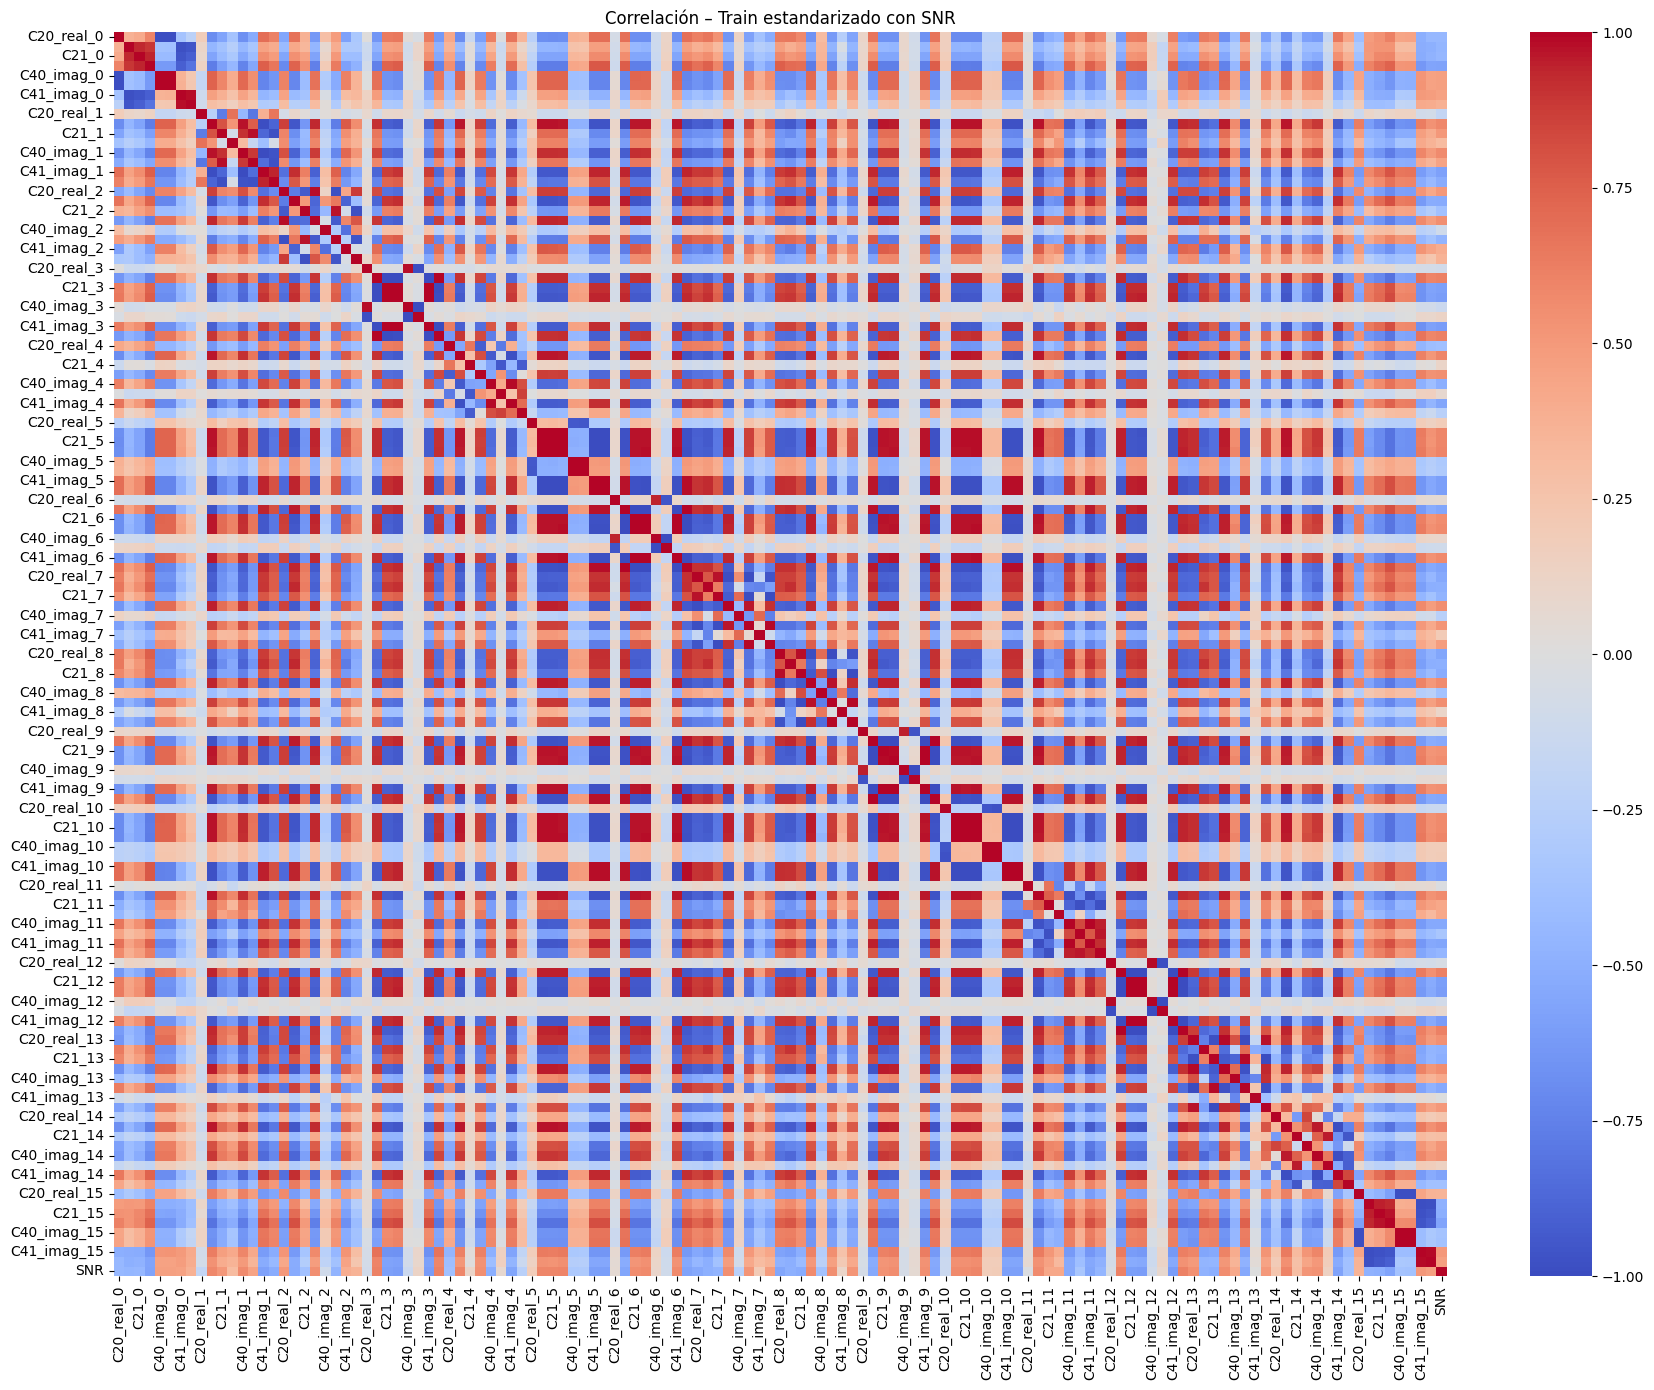

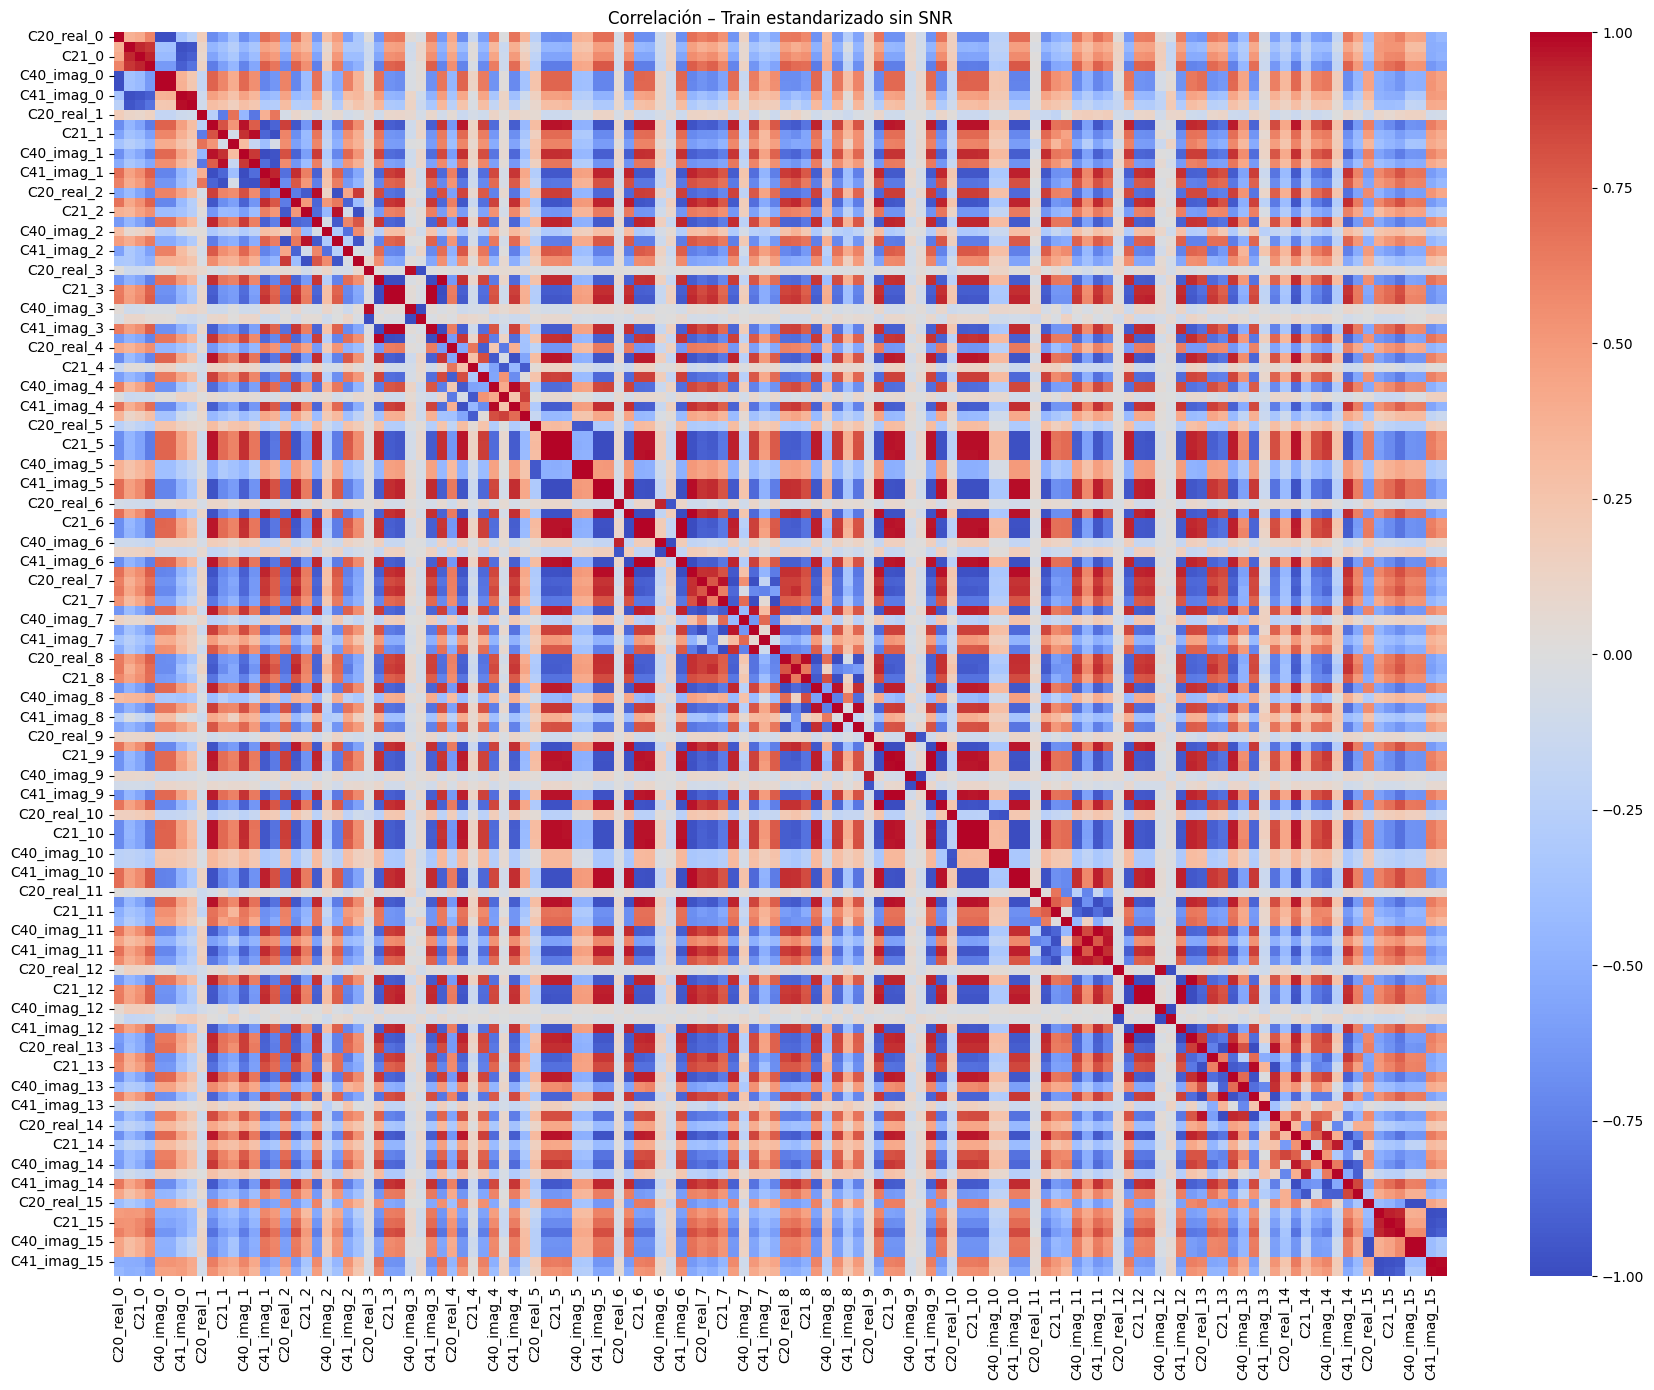

In [43]:
def construir_dataframe_features(X, incluir_snr=True):
    # Nombres de cumulantes
    nombres = []
    for k in range(16):
        nombres += [f"C20_real_{k}", f"C20_imag_{k}", f"C21_{k}",
                    f"C40_real_{k}", f"C40_imag_{k}",
                    f"C41_real_{k}", f"C41_imag_{k}", f"C42_{k}"]
    if incluir_snr:
        nombres.append("SNR")
    return pd.DataFrame(X, columns=nombres)


def calcular_matriz_correlacion(df):
    return df.corr()


def graficar_matriz_correlacion(matriz_corr, titulo="Matriz de correlación"):
    plt.figure(figsize=(18, 14))
    sns.heatmap(matriz_corr, cmap='coolwarm', center=0, vmax=1, vmin=-1)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()


# Construcción del DF y análisis para el dataset con SNR
df_con_snr = construir_dataframe_features(X_train_std, incluir_snr=True)
corr_con_snr = calcular_matriz_correlacion(df_con_snr)
graficar_matriz_correlacion(corr_con_snr, "Correlación – Train estandarizado con SNR")

# Construcción del DF y análisis para el dataset sin SNR
df_sin_snr = construir_dataframe_features(X_train_sin_snr_std, incluir_snr=False)
corr_sin_snr = calcular_matriz_correlacion(df_sin_snr)
graficar_matriz_correlacion(corr_sin_snr, "Correlación – Train estandarizado sin SNR")


**Bloques rojos** Cumulantes extremamente correlacionados

**Bloques azules** cumulantes anticorrelacionados

In [ ]:
def obtener_features_redundantes(corr_matrix, umbral=0.90):
    # Retorna lista de features redundantes usando la parte superior de la matriz
    
    corr_abs = corr_matrix.abs() # matriz de correlación absoluta (solo valores positivos)

    # crea una máscara triangular superior (matriz de 0/1) con ceros en la diagonal y en el triángulo inferior
    # la matriz es simétrica, por lo que se evita revisar dos veces el mismo par
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool)) # matriz de correlación absoluta donde solo la parte superior conserva los valores y el resto (triángulo inferior + diagonal) queda NaN

    # Lista de columnas para eliminar
    redundantes = set() # set() para evitar duplicados si varias comprobaciones apuntan a la misma columna

    ''' 
    recorro todos los pares (fila, columna) en la mitad superior y encuentro todos los pares
    con correlación mayor al umbral y si se detecta el par, se marca una de las dos features 
    a eliminar.
    '''
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > umbral: 
                redundantes.add(col)  # siempre se elimina la segunda columna del par
    return list(redundantes)


# Obtener columnas redundantes CON SNR
redundantes_con_snr = obtener_features_redundantes(corr_con_snr, umbral=0.90)
print(f"Features eliminadas (con SNR): {len(redundantes_con_snr)}")
print(redundantes_con_snr)

# Aplicar filtrado para eliminar todas las columnas que estén en la lista
df_con_snr_filtrado = df_con_snr.drop(columns=redundantes_con_snr)

# Volver a numpy
X_train_std_reducido = df_con_snr_filtrado.values

# Asegurar mismas columnas para test
df_test_con_snr = construir_dataframe_features(X_test_std, incluir_snr=True)
df_test_con_snr_filtrado = df_test_con_snr.drop(columns=redundantes_con_snr)
X_test_std_reducido = df_test_con_snr_filtrado.values

# Obtener columnas redundantes SIN SNR
redundantes_sin_snr = obtener_features_redundantes(corr_sin_snr, umbral=0.90)
print(f"\nFeatures eliminadas (sin SNR): {len(redundantes_sin_snr)}")
print(redundantes_sin_snr)

# Aplicar filtrado para eliminar todas las columnas que estén en la lista
df_sin_snr_filtrado = df_sin_snr.drop(columns=redundantes_sin_snr)

# Volver a numpy
X_train_sin_snr_std_reducido = df_sin_snr_filtrado.values

# Asegurar mismas columnas para test
df_test_sin_snr = construir_dataframe_features(X_test_sin_snr_std, incluir_snr=False)
df_test_sin_snr_filtrado = df_test_sin_snr.drop(columns=redundantes_sin_snr)
X_test_sin_snr_std_reducido = df_test_sin_snr_filtrado.values


Features eliminadas (con SNR): 97
['C42_10', 'C41_imag_11', 'C40_real_12', 'C41_imag_15', 'C40_imag_10', 'C41_real_11', 'C42_5', 'C42_2', 'C20_imag_9', 'C40_imag_14', 'C41_imag_0', 'C41_real_8', 'C40_real_3', 'C20_real_8', 'C42_9', 'C41_imag_1', 'C42_11', 'C40_real_7', 'C41_real_13', 'C40_real_8', 'C21_2', 'C20_real_13', 'C40_real_15', 'C40_imag_9', 'C40_imag_1', 'C20_imag_2', 'C41_imag_3', 'C40_real_10', 'C41_real_15', 'C41_imag_4', 'C21_9', 'C40_real_4', 'C20_imag_3', 'C41_real_0', 'C42_14', 'C40_real_5', 'C41_real_6', 'C42_13', 'C20_imag_12', 'C41_real_5', 'C42_3', 'C42_4', 'C41_real_9', 'C41_imag_9', 'C20_imag_13', 'C40_real_13', 'C41_imag_5', 'C41_real_1', 'C20_imag_6', 'C42_15', 'C40_imag_12', 'C41_real_10', 'C21_15', 'C40_imag_15', 'C40_imag_6', 'C41_real_12', 'C42_12', 'C40_real_0', 'C41_imag_10', 'C20_imag_4', 'C41_imag_12', 'C40_imag_5', 'C21_6', 'C41_real_4', 'C21_10', 'C21_13', 'C20_imag_14', 'C21_12', 'C42_7', 'C41_imag_14', 'C20_imag_8', 'C40_imag_0', 'C20_imag_7', 'C42_1

# **Entrenamiento de Modelos**

## **SVM**

In [54]:
# Hiperparámetros genéricos 

'''  
    - C es el hiperparámetro que controla qué tan estricto es el modelo con los errores.
        Un C grande es estricto e intenta clasificar todo bien, por lo que el margen en el hiperplano es pequeño
        Un C pequeño es más relajado y admite cierta cantidad de errores, resultando en un margen más ancho
        
    - gamma indica qué tan "curva" es la frontera (solo afecta a RBF)

    - los kernel inciden en la transformación que se le hará al espacio para darle forma al hiperplano en dimensiones mayores
    '''

param_grid_svm = {
    'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100], 
    'gamma': ['scale', 0.1, 0.5, 1, 2], 
    'degree': [2, 3, 4, 5],
    'kernel': ['rbf', 'linear', 'poly']   
}

### **Con SNR**

In [56]:

# Se instancia el modelo con el gridsearch, los hiperparámetros a probar, una validación cruzada de 5 folds
# la métrica para medir el desempeño será el accuracy
# 
grid_svm_snr = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_snr.fit(X_train_std_reducido, y_train)

# Resultados
best_svm_snr = grid_svm_snr.best_estimator_
print(f"Mejor configuración (Con SNR): {grid_svm_snr.best_params_}")
print(f"Accuracy en validación cruzada: {grid_svm_snr.best_score_:.4f}")

# Prueba final en test 
y_pred_svm_snr = best_svm_snr.predict(X_test_std_reducido)
print("\nReporte en TEST (Con SNR):")
print(classification_report(y_test, y_pred_svm_snr))

Mejor configuración (Con SNR): {'C': 0.5, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy en validación cruzada: 0.6982

Reporte en TEST (Con SNR):
              precision    recall  f1-score   support

           0       0.77      0.42      0.55        40
           1       0.81      0.95      0.87       100

    accuracy                           0.80       140
   macro avg       0.79      0.69      0.71       140
weighted avg       0.80      0.80      0.78       140



### **Sin SNR**

In [57]:

grid_svm_sin_snr = GridSearchCV(SVC(class_weight='balanced'), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm_sin_snr.fit(X_train_sin_snr_std_reducido, y_train) #

# Resultados
best_svm_sin_snr = grid_svm_sin_snr.best_estimator_
print(f"Mejor configuración (Sin SNR): {grid_svm_sin_snr.best_params_}")
print(f"Accuracy en validación cruzada: {grid_svm_sin_snr.best_score_:.4f}")

# Prueba final en test
y_pred_svm_sin_snr = best_svm_sin_snr.predict(X_test_sin_snr_std_reducido)
print("\nReporte en TEST (Sin SNR):")
print(classification_report(y_test, y_pred_svm_sin_snr))

Mejor configuración (Sin SNR): {'C': 0.5, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy en validación cruzada: 0.7036

Reporte en TEST (Sin SNR):
              precision    recall  f1-score   support

           0       0.78      0.45      0.57        40
           1       0.81      0.95      0.88       100

    accuracy                           0.81       140
   macro avg       0.80      0.70      0.72       140
weighted avg       0.80      0.81      0.79       140



**Recall** 0.42 / 0.45: Esto es lo más crítico. Significa que de cada 100 señales que realmente están limpias, el modelo se equivoca en 55 y dice que tienen interferencia.


**Recall** 0.95 (Clase 1): En cambio, detecta casi todas las interferencias reales.



**Con SNR** 80% Accuracy.

**Sin SNR** 81% Accuracy.

El valor de SNR, tal como está en los datos, confunde más de lo que ayuda. Al quitarlo, el modelo se obliga a mirar la forma de la constelación (los cumulantes), que es donde está la verdad.

## **Random Forest**

In [ ]:

# Hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250],  # Cantidad de árboles (más es mejor, pero más lento)
    'criterion': ['gini', 'entropy'],  # Forma de medir la calidad de la división
    'max_depth': [None,3, 5, 10, 15, 20],   # Profundidad (None deja que crezcan libres)
    'class_weight': ['balanced', 'balanced_subsample'] # CRUCIAL para el desbalance!
}


def optimizar_random_forest(X_train, y_train, X_test, y_test, nombre_dataset):
    
    # GridSearch
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid_rf,
        cv=5,               
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1          
    )
    
    # entrenamiento
    rf_grid.fit(X_train, y_train)


    # resultados del mejor modelo
    mejor_modelo = rf_grid.best_estimator_
    print(f"\nMejores Hiperparámetros encontrados: ")
    print(rf_grid.best_params_)
    print(f"Mejor Accuracy en Validación Cruzada: {rf_grid.best_score_:.4f}")
    
    # Predicción en test
    y_pred = mejor_modelo.predict(X_test)
    
    # Reporte final
    print("\n REPORTE DE CLASIFICACIÓN EN TEST:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusión Visual
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(f'Matriz de Confusión - RF {nombre_dataset}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad (0=No ICI, 1=Sí ICI)')
    plt.show()
    
    return mejor_modelo

### **Con SNR**

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores Hiperparámetros encontrados: 
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 75}
Mejor Accuracy en Validación Cruzada: 0.6982

 REPORTE DE CLASIFICACIÓN EN TEST:
              precision    recall  f1-score   support

           0       0.86      0.30      0.44        40
           1       0.78      0.98      0.87       100

    accuracy                           0.79       140
   macro avg       0.82      0.64      0.66       140
weighted avg       0.80      0.79      0.75       140



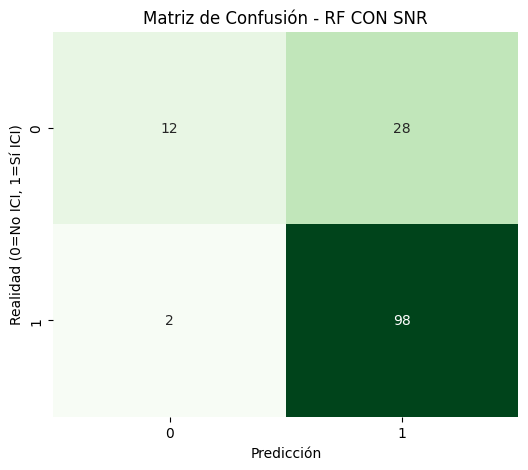

In [63]:
rf_con_snr_final = optimizar_random_forest(
    X_train_std_reducido, y_train,
    X_test_std_reducido, y_test,
    "CON SNR"
)

### **Sin SNR**

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejores Hiperparámetros encontrados: 
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 225}
Mejor Accuracy en Validación Cruzada: 0.7054

 REPORTE DE CLASIFICACIÓN EN TEST:
              precision    recall  f1-score   support

           0       0.88      0.35      0.50        40
           1       0.79      0.98      0.88       100

    accuracy                           0.80       140
   macro avg       0.83      0.67      0.69       140
weighted avg       0.81      0.80      0.77       140



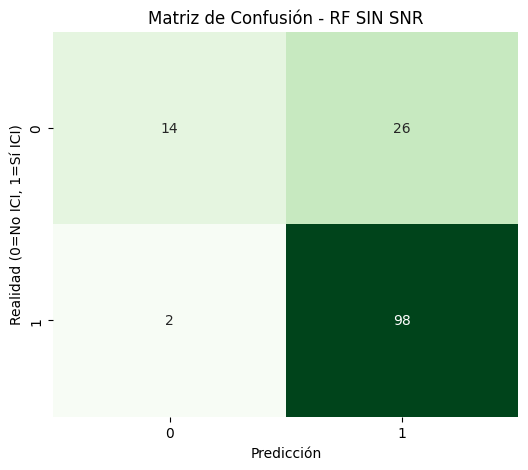

In [64]:
rf_sin_snr_final = optimizar_random_forest(
    X_train_sin_snr_std_reducido, y_train,
    X_test_sin_snr_std_reducido, y_test,
    "SIN SNR"
)

El Random Forest vio que había muchas más muestras de con ICI (Clase 1) y decidió irse por la fácil: **"Ante la duda, digo que sí hay interferencia"**. Por eso su acierto en la Clase 1 es casi perfecto (98%), pero ignora a los pocos casos limpios.

## **XGBoost**

In [76]:
param_grid_xgb = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],  # Número de ciclos de corrección
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Qué tan rápido aprende (menor es más preciso pero lento)
    'max_depth': [3, 5, 7],          # Profundidad de los árboles (XGB prefiere árboles bajitos)
    'subsample': [0.8, 1.0],         # Usar solo una parte de los datos para evitar memorizar
    'colsample_bytree': [0.8, 1.0]   # Usar solo algunas columnas por árbol
}

def optimizar_xgboost(X_train, y_train, X_test, y_test, nombre_dataset):
    
    # configuración el modelo
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    
    grid = GridSearchCV(
        xgb,
        param_grid_xgb,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # entrenamiento
    grid.fit(X_train, y_train)
    
    # Resultados
    mejor_modelo = grid.best_estimator_
    print(f"\nMejores Hiperparámetros:")
    print(grid.best_params_)
    print(f"Mejor Accuracy en Validación Cruzada: {grid.best_score_:.4f}")
    
    # Predicción
    y_pred = mejor_modelo.predict(X_test)
    
    # Reporte
    print("\nREPORTE DE CLASIFICACIÓN EN TEST:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False) # Usamos Naranja para diferenciar
    plt.title(f'Matriz de Confusión - XGBoost {nombre_dataset}')
    plt.ylabel('Realidad (0=No ICI, 1=Sí ICI)')
    plt.xlabel('Predicción')
    plt.show()
    
    return mejor_modelo

### **Con SNR**

Fitting 5 folds for each of 336 candidates, totalling 1680 fits

Mejores Hiperparámetros:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Mejor Accuracy en Validación Cruzada: 0.7000

REPORTE DE CLASIFICACIÓN EN TEST:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.71      1.00      0.83       100

    accuracy                           0.71       140
   macro avg       0.36      0.50      0.42       140
weighted avg       0.51      0.71      0.60       140



C:\Users\valen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\valen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\valen\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

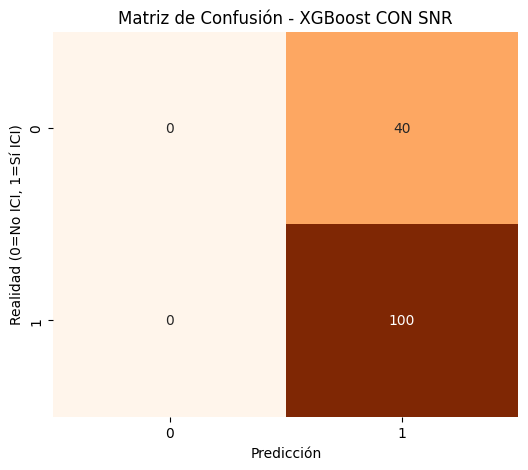

In [77]:
xgb_con_snr_final = optimizar_xgboost(
    X_train_std_reducido, y_train,
    X_test_std_reducido, y_test,
    "CON SNR"
)

### **Sin SNR**

Fitting 5 folds for each of 336 candidates, totalling 1680 fits

Mejores Hiperparámetros:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Mejor Accuracy en Validación Cruzada: 0.7107

REPORTE DE CLASIFICACIÓN EN TEST:
              precision    recall  f1-score   support

           0       0.82      0.23      0.35        40
           1       0.76      0.98      0.86       100

    accuracy                           0.76       140
   macro avg       0.79      0.60      0.60       140
weighted avg       0.78      0.76      0.71       140



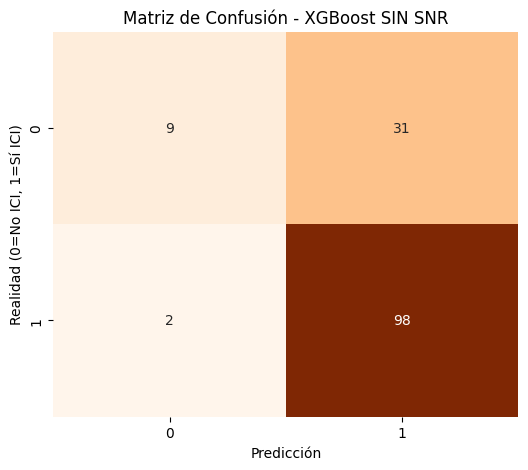

In [78]:
xgb_sin_snr_final = optimizar_xgboost(
    X_train_sin_snr_std_reducido, y_train,
    X_test_sin_snr_std_reducido, y_test,
    "SIN SNR"
)

El algoritmo se dio cuenta de algo tramposo: "Oye, si digo que TODO es interferencia (1), acierto el 71% de las veces sin esforzarme".

Esto se llama "Mode Collapse" (colapso de moda) hacia la clase mayoritaria. Ningún ajuste de hiperparámetros (learning_rate, depth) va a arreglar esto, porque el problema es la geometría de los datos.

# **Métricas de Evaluación**

– Accuracy, Precision, Recall, F1-score.
– Matriz de confusión.
– Comparación de rendimiento con y sin SNR.

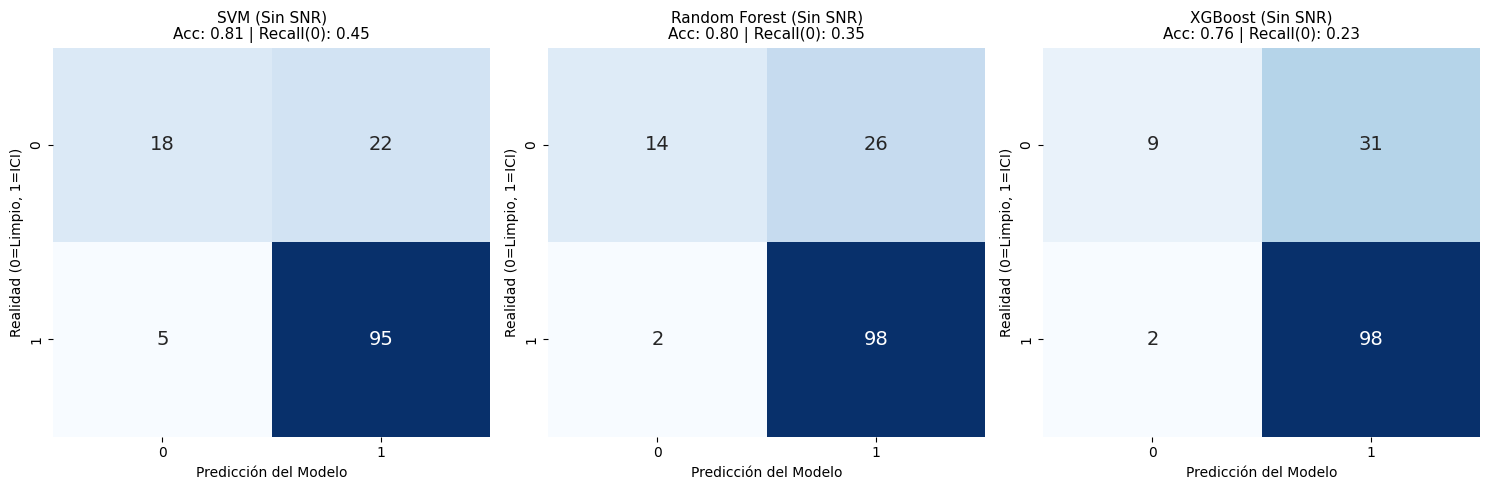


TABLA DE MÉTRICAS DETALLADAS:


,Modelo,Accuracy,Recall (No ICI),Recall (Sí ICI),F1-Macro
0,SVM (Sin SNR),0.8071,0.450,0.95,0.7235
1,Random Forest (Sin SNR),0.8000,0.350,0.98,0.6875
2,XGBoost (Sin SNR),0.7643,0.225,0.98,0.6044


C:\Users\valen\AppData\Local\Temp\ipykernel_15952\2556222636.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x='Modelo', y='Recall (No ICI)', palette='viridis')


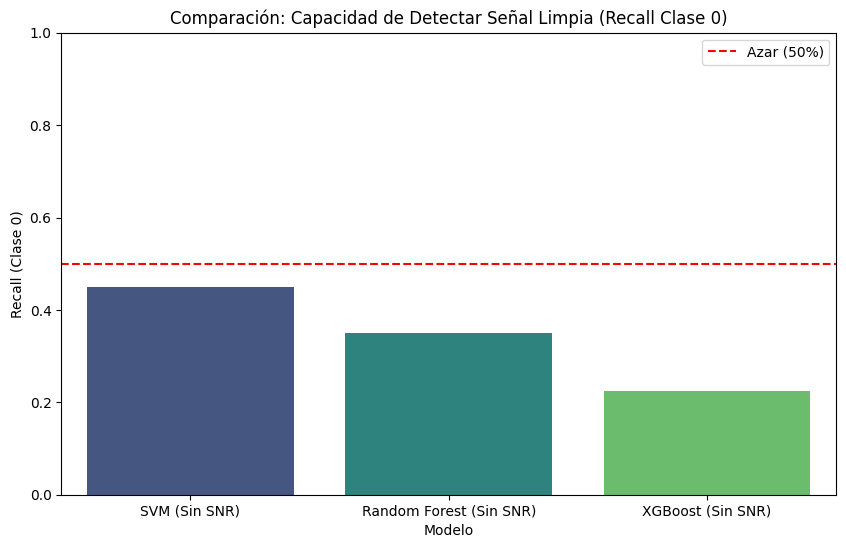

In [82]:


# Lista de mejores modelos a comparar sin SNR
modelos_a_evaluar = {
    "SVM (Sin SNR)": best_svm_sin_snr,      
    "Random Forest (Sin SNR)": rf_sin_snr_final, 
    "XGBoost (Sin SNR)": xgb_sin_snr_final  }

# Variable para guardar métricas y hacer el gráfico final
resultados_finales = []


plt.figure(figsize=(15, 5)) # Configuración para mostrar las matrices en una fila

for i, (nombre, modelo) in enumerate(modelos_a_evaluar.items()):
    
    # Predecir
    y_pred = modelo.predict(X_test_sin_snr_std_reducido)
    
    # Calcular Métricas Clave
    acc = accuracy_score(y_test, y_pred)
    recall_0 = recall_score(y_test, y_pred, pos_label=0) # Capacidad de detectar NO ICI
    recall_1 = recall_score(y_test, y_pred, pos_label=1) # Capacidad de detectar SÍ ICI
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    # Guardar para el resumen
    resultados_finales.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Recall (No ICI)': recall_0,
        'Recall (Sí ICI)': recall_1,
        'F1-Macro': f1_macro
    })
    
    # Graficar Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, i+1) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f"{nombre}\nAcc: {acc:.2f} | Recall(0): {recall_0:.2f}", fontsize=11)
    plt.ylabel('Realidad (0=Limpio, 1=ICI)')
    plt.xlabel('Predicción del Modelo')

plt.tight_layout()
plt.show()

# Tabla de resumen
df_resultados = pd.DataFrame(resultados_finales)
print("\nTABLA DE MÉTRICAS DETALLADAS:")
display(df_resultados.round(4)) 

# Gráfico de Barras Comparativo 
# se compara qué tan bueno fue cada uno detectando la Clase 0 (la difícil)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados, x='Modelo', y='Recall (No ICI)', palette='viridis')
plt.axhline(y=0.5, color='r', linestyle='--', label='Azar (50%)')
plt.title('Comparación: Capacidad de Detectar Señal Limpia (Recall Clase 0)')
plt.ylabel('Recall (Clase 0)')
plt.ylim(0, 1.0)
plt.legend()
plt.show()